In [5]:
#pip install gluonts
#!pip install mxnet==1.6.0

In [6]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd "/content/drive/My Drive/"

In [7]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from gluonts.mx import DeepAREstimator, Trainer

/usr/local/lib/python3.8/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [9]:
df = pd.read_csv("energydata_complete.csv")
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [10]:
df.columns

Index(['date', 'Appliances', 'lights', 'T1', 'RH_1', 'T2', 'RH_2', 'T3',
       'RH_3', 'T4', 'RH_4', 'T5', 'RH_5', 'T6', 'RH_6', 'T7', 'RH_7', 'T8',
       'RH_8', 'T9', 'RH_9', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed',
       'Visibility', 'Tdewpoint', 'rv1', 'rv2'],
      dtype='object')

In [13]:
df_input = df[['date', 'Appliances', 'T_out', 'Press_mm_hg', 'RH_out', 'Windspeed','Visibility', 'Tdewpoint']]
df_input  = df_input.set_index('date')

In [18]:
prediction_length = 144 #  Predicting next day: As observations are evry 10 min 
                        #  so in hour total 6 observation and in a day 144
train_time = "2016-05-10 00:00:00"

In [21]:
estimator = DeepAREstimator( freq = "10min",
                            context_length = 720,
                            prediction_length = prediction_length,
                            num_layers= 2,
                            num_cells= 128,
                            cell_type='lstm',
                            trainer = Trainer(epochs=8)
                            )

In [24]:
from gluonts.dataset.common import ListDataset
training_data = ListDataset(
    [
        {"start":df_input.index[0], "target":df_input.Appliances[:train_time]}
    ],
    freq = "10min"
)

In [25]:
predictor = estimator.train(training_data = training_data)

100%|██████████| 50/50 [05:08<00:00,  6.17s/it, epoch=8/8, avg_epoch_loss=4.39]


In [27]:
test_data = ListDataset(
    [
        {"start":df_input.index[0], "target":df_input.Appliances[:"2016-05-11 00:00:00"]},
        {"start":df_input.index[0], "target":df_input.Appliances[:"2016-05-15 00:00:00"]}
    ],
    freq = "10min"
)

In [28]:
from gluonts.evaluation.backtest import make_evaluation_predictions

In [29]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_data,
    predictor = predictor,
    num_samples=100
)

In [30]:
forecasts = list(forecast_it)
tss = list(ts_it)
forecast_entry=  forecasts[0]
ts_entry = tss[0]
forecast_entry


gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[59.809776, 53.43702 , 43.385666, ..., 53.615364, 42.001453,
        45.17554 ],
       [69.25838 , 61.915638, 63.758   , ..., 26.305359, 37.99426 ,
        35.570778],
       [47.31292 , 46.658   , 47.0023  , ..., 43.8901  , 36.407276,
        47.307594],
       ...,
       [53.762302, 56.86011 , 49.779293, ..., 53.32142 , 55.823635,
        58.53645 ],
       [44.1899  , 55.619755, 57.42229 , ..., 30.74121 , 34.689682,
        38.36542 ],
       [61.639793, 47.283463, 55.12971 , ..., 34.447464, 37.804756,
        39.169933]], dtype=float32), start_date=Period('2016-05-10 00:10', '10T'))

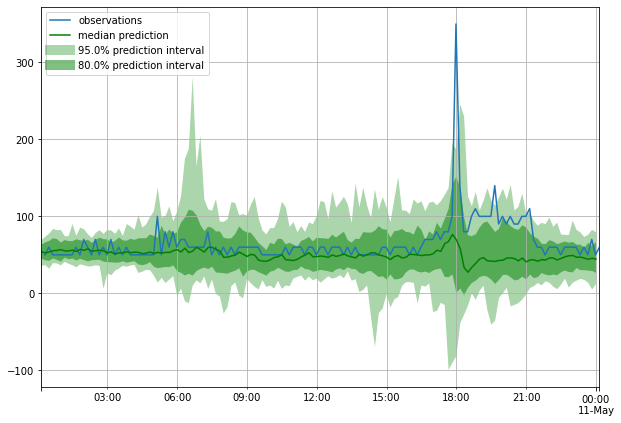

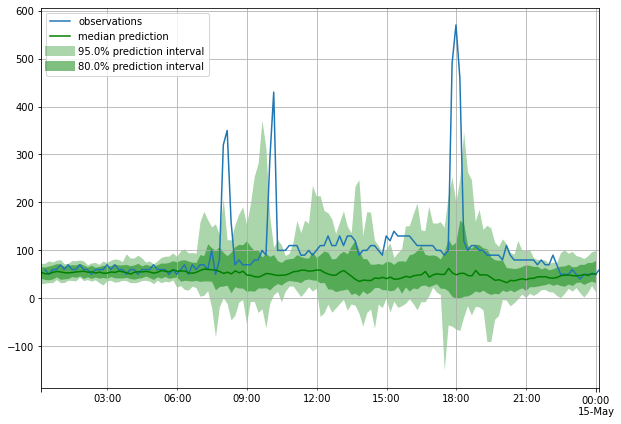

In [31]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = prediction_length
    prediction_intervals = (80.0, 95.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

plot_prob_forecasts(tss[0], forecasts[0])
plot_prob_forecasts(tss[1], forecasts[1])

In [32]:
from gluonts.evaluation import Evaluator
evaluator = Evaluator(quantiles=[0.1,0.5, 0.9])
agg_metrics, item_metrics = evaluator(tss, forecasts)


Running evaluation: 2it [00:00, 32.73it/s]
